In [1]:
# general purpose libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# torch libraries
import torch
import torch.nn as nn
import torchmetrics
from torcheval.metrics.functional import binary_auprc

# model libraries
from neural_net_pre_process import RNAData

In [2]:
DATA_PATH = os.path.join(".", "data", "dataset0.json.gz")
LABEL_PATH = os.path.join(".", "data", "data.info")
BATCH_SIZE = 128
READ_SIZE = 20
TRAIN_SIZE = 0.8  # Specify the training size if you're using train-test split

rna_data = RNAData(data_path=DATA_PATH, label_path=LABEL_PATH, batch_size=BATCH_SIZE, read_size=READ_SIZE, train=True, train_size=TRAIN_SIZE)


Currently pre processing ...
Pre processing done!
Currently labelling ...
Labelling done
Currently Splitting ...
Splitting done
Currently encoding ...
Encoding done


In [3]:
rna_data

In [4]:
# Switch to train mode
rna_data.train_mode()
    
# Get training data
train_data_loader = rna_data.data_loader()
    
 # Extract features (X) and labels (y) for training
X_train, y_train = zip(*[batch for batch in train_data_loader])
X_train = torch.cat(X_train)
y_train = torch.cat(y_train)

In [5]:
# Switch to eval mode
rna_data.eval_mode()

# Get test data
test_data_loader = rna_data.data_loader()
    
# Extract features (X) and labels (y) for testing
X_test, y_test = zip(*[batch for batch in test_data_loader])
X_test = torch.cat(X_test)
y_test = torch.cat(y_test)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([97499, 20, 12])
torch.Size([97499])
torch.Size([24339, 20, 12])
torch.Size([24339])


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

def logistic_regression(X_train, y_train, X_test, y_test, c, reg):
    """
    Perform logistic regression, evaluate the model, and plot ROC and PRC curves.

    Parameters:
    X_train (torch.Tensor): Training features.
    y_train (torch.Tensor): Training labels.
    X_test (torch.Tensor): Testing features.
    y_test (torch.Tensor): Testing labels.

    Returns:
    None
    """

    # Fit the logistic regression model
    model = LogisticRegression(solver="saga", C=c, penalty=reg)
    model.fit(X_train.view(X_train.size(0), -1), y_train)  # Flatten X_train to 2D

    # Predict probabilities
    y_pred = model.predict(X_test.view(X_test.size(0), -1))  # Flatten X_test to 2D
    y_pred_prob = model.predict_proba(X_test.view(X_test.size(0), -1))[:, 1]

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    # Calculate the area under the Precision-Recall Curve (PRC)
    prc_auc = average_precision_score(y_test, y_pred_prob)

    # Print ROC AUC score
    print('ROC AUC Score:', roc_auc)

    # Print PRC score
    print('PRC AUC Score:', prc_auc)

    # Plot ROC and PRC curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label='PRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()


c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     23107
           1       0.13      0.72      0.22      1232

    accuracy                           0.75     24339
   macro avg       0.56      0.73      0.54     24339
weighted avg       0.94      0.75      0.82     24339

ROC AUC Score: 0.8190700841764371
PRC AUC Score: 0.3046434957160937


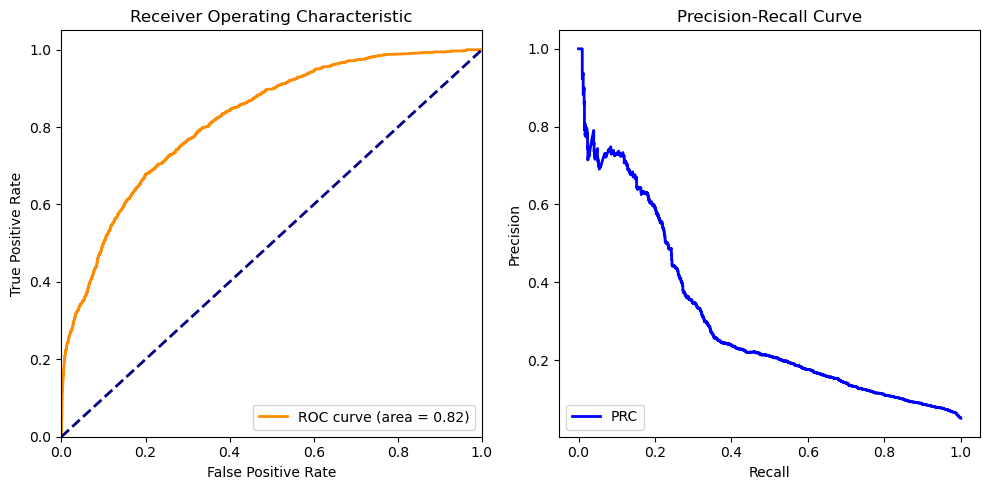

In [8]:
logistic_regression(X_train, y_train, X_test, y_test, 1, None)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score

def logistic_regression(X_train, y_train, X_test, y_test, c, reg):
    """
    Perform logistic regression, evaluate the model, and plot ROC and PRC curves.

    Parameters:
    X_train (torch.Tensor): Training features.
    y_train (torch.Tensor): Training labels.
    X_test (torch.Tensor): Testing features.
    y_test (torch.Tensor): Testing labels.
    c (list): List of regularization strengths to search.
    reg (list): List of regularization types to search (e.g., 'l1', 'l2').

    Returns:
    None
    """

    # Define the hyperparameters to search
    param_grid = {'C': c, 'penalty': reg}

    # Create a logistic regression model
    model = LogisticRegression(solver="saga")

    # Create a grid search cross-validation model
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='average_precision')

    # Fit the grid search model
    grid_search.fit(X_train.view(X_train.size(0), -1), y_train)

    # Get the best hyperparameters from the grid search
    best_c = grid_search.best_params_['C']
    best_reg = grid_search.best_params_['penalty']

    # Fit the logistic regression model with the best hyperparameters
    best_model = LogisticRegression(solver="saga", C=best_c, penalty=best_reg)
    best_model.fit(X_train.view(X_train.size(0), -1), y_train)

    # Predict probabilities
    y_pred = best_model.predict(X_test.view(X_test.size(0), -1))  # Flatten X_test to 2D
    y_pred_prob = best_model.predict_proba(X_test.view(X_test.size(0), -1))[:, 1]

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    # Calculate the area under the Precision-Recall Curve (PRC)
    prc_auc = average_precision_score(y_test, y_pred_prob)

    # Print ROC AUC score
    print('ROC AUC Score:', roc_auc)

    # Print PRC score
    print('PRC AUC Score:', prc_auc)

    # Plot ROC and PRC curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label='PRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

    return grid_search

def visualize_grid_search_results(grid_search):
    results = grid_search.cv_results_

    # Extract the hyperparameters and performance scores
    c_values = np.array(results['param_C'].data, dtype=float)
    reg_types = results['param_penalty']
    mean_test_scores = results['mean_test_score']
    
    # Create a heatmap to visualize the mean test scores
    unique_c_values = np.unique(c_values)
    unique_reg_types = np.unique(reg_types)

    heatmap_data = np.zeros((len(unique_reg_types), len(unique_c_values)))

    for i, c in enumerate(unique_c_values):
        for j, reg in enumerate(unique_reg_types):
            mask = (c_values == c) & (reg_types == reg)
            score = mean_test_scores[mask]
            heatmap_data[j, i] = score[0]  # Assuming there's only one score per combination

    # Create a table to show mean test scores
    results_df = pd.DataFrame(results)
    relevant_columns = ['param_C', 'param_penalty', 'mean_test_score', 'std_test_score']
    table = results_df[relevant_columns].sort_values(by='mean_test_score', ascending=False)

    print("Grid Search Results Table:")
    print(table)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     23107
           1       0.13      0.72      0.22      1232

    accuracy                           0.75     24339
   macro avg       0.56      0.73      0.54     24339
weighted avg       0.94      0.75      0.82     24339

ROC AUC Score: 0.819083011051354
PRC AUC Score: 0.30460669238335636


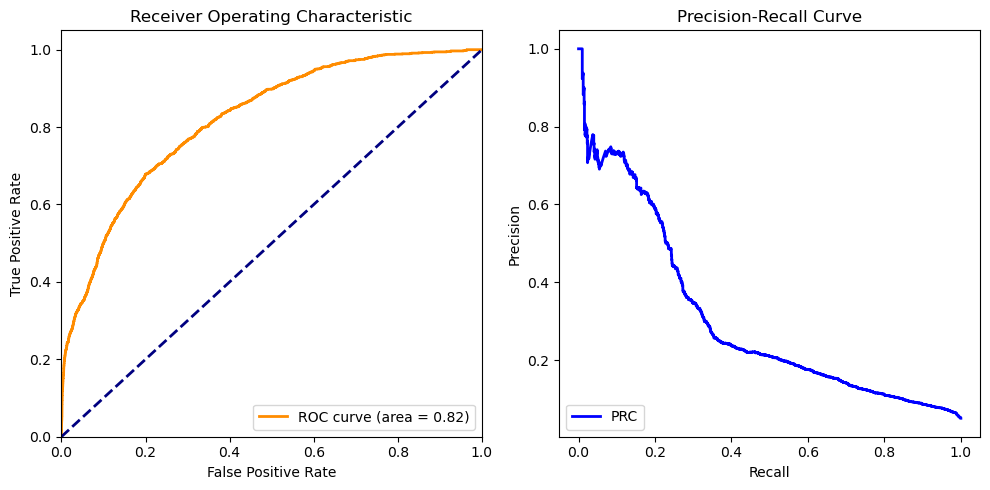

In [10]:
c_values = [0.1, 1.0, 10.0]  # List of regularization strengths to search
reg_types = ['l1', 'l2']  # List of regularization types to search

gs = logistic_regression(X_train, y_train, X_test, y_test, c_values, reg_types)


In [11]:
visualize_grid_search_results(gs)

Grid Search Results Table:
  param_C param_penalty  mean_test_score  std_test_score
0     0.1            l1         0.826319        0.003589
2     1.0            l1         0.826293        0.003581
4    10.0            l1         0.826293        0.003580
1     0.1            l2         0.826293        0.003580
5    10.0            l2         0.826293        0.003580
3     1.0            l2         0.826292        0.003580


In [13]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def xgboost_classification(X_train, y_train, X_test, y_test, params):
    """
    Perform XGBoost classification, evaluate the model, and print a classification report.
    Plot ROC and PRC curves.

    Parameters:
    X_train (torch.Tensor): Training features.
    y_train (torch.Tensor): Training labels.
    X_test (torch.Tensor): Testing features.
    y_test (torch.Tensor): Testing labels.
    params (dict): Dictionary of XGBoost hyperparameters to search.

    Returns:
    None
    """

    # Create an XGBoost classifier
    xgb_classifier = xgb.XGBClassifier()

    # Create a grid search cross-validation model
    grid_search = GridSearchCV(xgb_classifier, params, cv=5, n_jobs=-1, scoring='average_precision', verbose=2)

    # Fit the grid search model
    grid_search.fit(X_train.view(X_train.size(0), -1), y_train)

    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_

    # Create an XGBoost classifier with the best hyperparameters
    best_xgb_classifier = xgb.XGBClassifier(**best_params)

    # Set the evaluation metrics for AUC and AUCPR
    eval_metrics = ["auc", "aucpr"]

    # Fit the XGBoost model with the best hyperparameters and evaluation metrics
    best_xgb_classifier.fit(
        X_train.view(X_train.size(0), -1),
        y_train,
        eval_metric=eval_metrics,  # Use AUC and AUCPR as evaluation metrics
        eval_set=[(X_test.view(X_test.size(0), -1), y_test)]
    )

    # Predict labels
    y_pred = best_xgb_classifier.predict(X_test.view(X_test.size(0), -1))

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, best_xgb_classifier.predict_proba(X_test.view(X_test.size(0), -1))[:, 1])
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, best_xgb_classifier.predict_proba(X_test.view(X_test.size(0), -1))[:, 1])
    prc_auc = average_precision_score(y_test, best_xgb_classifier.predict_proba(X_test.view(X_test.size(0), -1))[:, 1])

    # Print ROC AUC score
    print('ROC AUC Score:', roc_auc)

    # Print PRC AUC score
    print('PRC AUC Score:', prc_auc)

    # Plot ROC and PRC curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label='PRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

    return grid_search


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\jonas\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83537	validation_0-aucpr:0.26560
[1]	validation_0-auc:0.85226	validation_0-aucpr:0.32597
[2]	validation_0-auc:0.85542	validation_0-aucpr:0.33627
[3]	validation_0-auc:0.86335	validation_0-aucpr:0.36346
[4]	validation_0-auc:0.86817	validation_0-aucpr:0.37946
[5]	validation_0-auc:0.87277	validation_0-aucpr:0.38996
[6]	validation_0-auc:0.87628	validation_0-aucpr:0.40241
[7]	validation_0-auc:0.87874	validation_0-aucpr:0.41532
[8]	validation_0-auc:0.88181	validation_0-aucpr:0.42662
[9]	validation_0-auc:0.88443	validation_0-aucpr:0.43723
[10]	validation_0-auc:0.88631	validation_0-aucpr:0.44313
[11]	validation_0-auc:0.88759	validation_0-aucpr:0.44757
[12]	validation_0-auc:0.88924	validation_0-aucpr:0.45149
[13]	validation_0-auc:0.89012	validation_0-aucpr:0.45584
[14]	validation_0-auc:0.89128	validation_0-aucpr:0.45894
[15]	validation_0-auc:0.89253	validation_0-aucpr:0.46432
[16]	validation_0-auc:0.89355	validation_0-aucpr:0.46713
[17]	validation_0-auc:0.89488	validation_

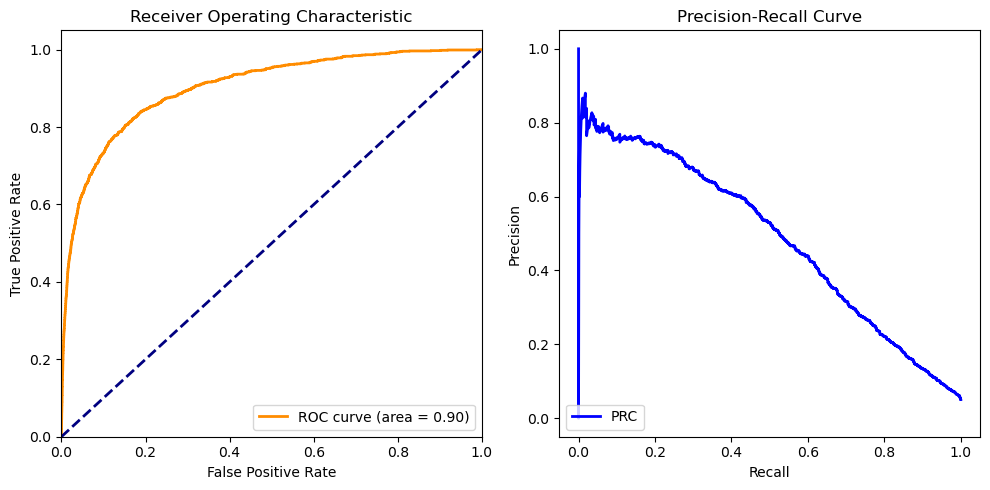

In [14]:
# Define XGBoost hyperparameters to search
xgboost_params = {
    'subsample': [1],
    'learning_rate': [0.3],
    'max_depth': [6]
}

# Call the XGBoost classification function
xgboost_grid_search = xgboost_classification(X_train, y_train, X_test, y_test, xgboost_params)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\jonas\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83537	validation_0-aucpr:0.26560
[1]	validation_0-auc:0.84266	validation_0-aucpr:0.28683
[2]	validation_0-auc:0.84826	validation_0-aucpr:0.30437
[3]	validation_0-auc:0.85117	validation_0-aucpr:0.31760
[4]	validation_0-auc:0.85621	validation_0-aucpr:0.33730
[5]	validation_0-auc:0.85725	validation_0-aucpr:0.34103
[6]	validation_0-auc:0.85795	validation_0-aucpr:0.34278
[7]	validation_0-auc:0.86044	validation_0-aucpr:0.35524
[8]	validation_0-auc:0.86379	validation_0-aucpr:0.36541
[9]	validation_0-auc:0.86590	validation_0-aucpr:0.37296
[10]	validation_0-auc:0.86844	validation_0-aucpr:0.37736
[11]	validation_0-auc:0.87089	validation_0-aucpr:0.39051
[12]	validation_0-auc:0.87175	validation_0-aucpr:0.39313
[13]	validation_0-auc:0.87280	validation_0-aucpr:0.39797
[14]	validation_0-auc:0.87365	validation_0-aucpr:0.40125
[15]	validation_0-auc:0.87470	validation_0-aucpr:0.40652
[16]	validation_0-auc:0.87551	validation_0-aucpr:0.40963
[17]	validation_0-auc:0.87714	validation_

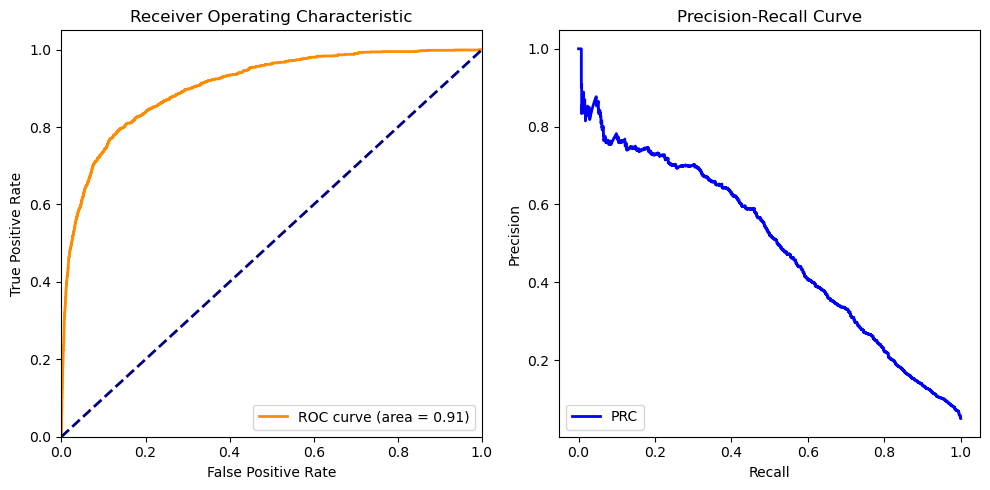

In [16]:
# Define XGBoost hyperparameters to search
xgboost_params = {
    'subsample': [0.9, 1],
    'learning_rate': [0.1, 0.3],
    'max_depth': [5, 6]
}

# Call the XGBoost classification function
xgboost_grid_search = xgboost_classification(X_train, y_train, X_test, y_test, xgboost_params)


In [18]:
xgboost_grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'subsample': 1}

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\jonas\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83537	validation_0-aucpr:0.26560
[1]	validation_0-auc:0.84266	validation_0-aucpr:0.28683
[2]	validation_0-auc:0.84826	validation_0-aucpr:0.30437
[3]	validation_0-auc:0.85117	validation_0-aucpr:0.31760
[4]	validation_0-auc:0.85621	validation_0-aucpr:0.33730
[5]	validation_0-auc:0.85725	validation_0-aucpr:0.34103
[6]	validation_0-auc:0.85795	validation_0-aucpr:0.34278
[7]	validation_0-auc:0.86044	validation_0-aucpr:0.35524
[8]	validation_0-auc:0.86379	validation_0-aucpr:0.36541
[9]	validation_0-auc:0.86590	validation_0-aucpr:0.37296
[10]	validation_0-auc:0.86844	validation_0-aucpr:0.37736
[11]	validation_0-auc:0.87089	validation_0-aucpr:0.39051
[12]	validation_0-auc:0.87175	validation_0-aucpr:0.39313
[13]	validation_0-auc:0.87280	validation_0-aucpr:0.39797
[14]	validation_0-auc:0.87365	validation_0-aucpr:0.40125
[15]	validation_0-auc:0.87470	validation_0-aucpr:0.40652
[16]	validation_0-auc:0.87551	validation_0-aucpr:0.40963
[17]	validation_0-auc:0.87714	validation_

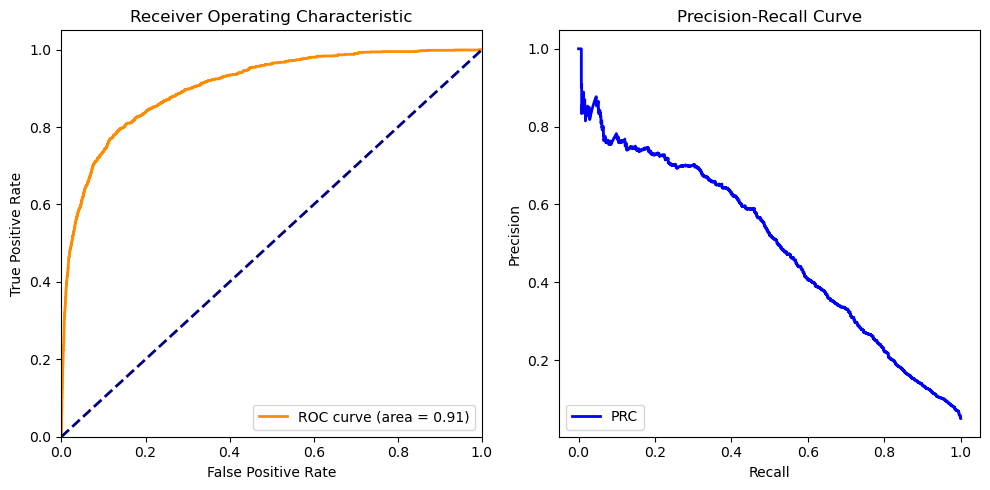

In [19]:
# Define XGBoost hyperparameters to search
xgboost_params = {
    'subsample': [0.8, 1],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6]
}

# Call the XGBoost classification function
xgboost_grid_search = xgboost_classification(X_train, y_train, X_test, y_test, xgboost_params)

In [20]:
xgboost_grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'subsample': 1}